In [3]:
import gymnasium as gym
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import imageio
import time

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [25]:
# Numero di ambienti paralleli per il training
NUM_ENVS = 4


# Wrapper personalizzato per modificare la ricompensa
class CustomRewardWrapper(gym.Wrapper):
    """
    Wrapper personalizzato che modifica la funzione di ricompensa dell'ambiente.

    Penalizza il robot se il torso si inclina troppo all'indietro (indicando una caduta),
    aumentando la penalità nel tempo finché rimane in questa posizione.
    """

    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        """
        Esegue un passo nell'ambiente e modifica la ricompensa in base all'inclinazione del torso.

        Args:
            action (np.array): Azione scelta dall'agente.

        Returns:
            tuple: Osservazione successiva, ricompensa modificata, stato di terminazione, stato di troncamento, info extra.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        torso_angle = self.env.unwrapped.data.qpos[2]  # Angolo del torso

        # Inizializza il timer della caduta se non esiste
        if not hasattr(self, 'cappottato_start_time'):
            self.cappottato_start_time = None

        if torso_angle < -0.7:  # Se il robot è caduto
            if self.cappottato_start_time is None:  # Se è la prima volta che cade
                self.cappottato_start_time = time.time()  # Registra il tempo di inizio caduta

            tempo_cappottato = time.time() - self.cappottato_start_time  # Tempo trascorso in stato di caduta
            penalty = 50 * tempo_cappottato  # Penalità proporzionale al tempo caduto
            reward -= penalty  # Sottrae la penalità alla ricompensa

        else:  # Se il robot non è più in stato di caduta
            self.cappottato_start_time = None  # Resetta il timer

        return obs, reward, terminated, truncated, info


# Funzione per creare un ambiente monitorato con la ricompensa personalizzata
def make_env():
    """
    Crea e restituisce un'istanza dell'ambiente "HalfCheetah-v5" con parametri personalizzati,
    monitoraggio delle prestazioni e applicazione del CustomRewardWrapper.

    Returns:
        function: Funzione che inizializza l'ambiente quando chiamata.
    """

    def _init():
        env = gym.make("HalfCheetah-v5",
                       reset_noise_scale=0.013459312664159742,  # Intensità del rumore iniziale
                       forward_reward_weight=1.4435374113892951,  # Peso della ricompensa di avanzamento
                       ctrl_cost_weight=0.09129087622076545)  # Peso del costo dell'azione
        env = Monitor(env)  # Registra metriche dell'episodio
        env = CustomRewardWrapper(env)  # Applica la ricompensa modificata
        return env

    return _init


# Creazione degli ambienti per il training con parallelizzazione
env = SubprocVecEnv([make_env() for _ in range(NUM_ENVS)])  # Parallelizza 4 ambienti
env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)  # Normalizza solo le osservazioni

# Selezione automatica della GPU se disponibile
device = "cuda" if torch.cuda.is_available() else "cpu"

# Parametri del modello PPO
model_params = {
    "policy": "MlpPolicy",  # Rete neurale per la politica
    "env": env,  # Ambiente di training
    "learning_rate": 0.0006365820963392328,  # Tasso di apprendimento ottimizzato
    "n_steps": 2048,  # Passi prima di ogni aggiornamento
    "batch_size": 1024,  # Dimensione del batch per l'update
    "n_epochs": 10,  # Numero di epoche per aggiornare la politica
    "gamma": 0.9932509667338772,  # Fattore di sconto per le ricompense future
    "gae_lambda": 0.9196254842611007,  # Trade-off tra bias e varianza nel GAE
    "clip_range": 0.19119739932498195,  # Clipping per la stabilità dell'aggiornamento
    "ent_coef": 0.007152371678457134,  # Peso della perdita di entropia per incentivare l'esplorazione
    "verbose": 1,  # Livello di log
    "tensorboard_log": "./ppo_HalfCheetah_tensorboard/",  # Percorso di log per TensorBoard
    "device": device,  # CPU o GPU
    "policy_kwargs": dict(net_arch=[256, 256, 128])  # Architettura della rete neurale
}

# Creazione dell'ambiente di valutazione
eval_env = DummyVecEnv([make_env()])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.,
                        training=False)  # Solo normalizzazione osservazioni

# Callback per la valutazione e il salvataggio periodico del modello
eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/best_model",
                             log_path="./logs/", eval_freq=5000, deterministic=True, render=False)
checkpoint_callback = CheckpointCallback(save_freq=5000, save_path="./logs/checkpoints/",
                                         name_prefix="ppo_halfcheetah_checkpoint")

# Creazione e addestramento del modello PPO
model = PPO(**model_params)
model.learn(total_timesteps=1_500_000, callback=CallbackList([eval_callback, checkpoint_callback]))

# Salvataggio del modello e della normalizzazione dell'ambiente
model.save("ppo_HalfCheetah_model")
env.save("vecnormalize_HalfCheetah.pkl")

# Caricamento del modello e della normalizzazione per la valutazione
model = PPO.load("ppo_HalfCheetah_model", device=device)
eval_env = VecNormalize.load("vecnormalize_HalfCheetah.pkl", eval_env)
eval_env.training = False  # Disattiva la normalizzazione durante la valutazione
eval_env.reset()


# Funzione per valutare l'agente su più episodi
def evaluate_agent(model, env, episodes=100):
    """
    Valuta le prestazioni dell'agente addestrato su un numero di episodi.

    Args:
        model (PPO): Modello PPO addestrato.
        env (VecNormalize): Ambiente di valutazione.
        episodes (int): Numero di episodi su cui eseguire la valutazione.

    Returns:
        tuple: Media e deviazione standard della ricompensa ottenuta.
    """
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=episodes, deterministic=True)
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    return mean_reward, std_reward


# Valutazione del modello allenato
mean_reward_trained, std_reward_trained = evaluate_agent(model, eval_env, episodes=100)


Using cpu device
Logging to ./ppo_HalfCheetah_tensorboard/PPO_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -362     |
| time/              |          |
|    fps             | 9027     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -308         |
| time/                   |              |
|    fps                  | 7214         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0092215715 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.191        |
|    entropy_loss         | -8.5    

In [26]:
# 5. Salviamo il modello e i parametri di normalizzazione

# Salva il modello PPO addestrato per poterlo riutilizzare senza doverlo addestrare nuovamente.
model.save("ppo_HalfCheetah_model")

# Salva lo stato dell'ambiente normalizzato, inclusi i parametri di normalizzazione delle osservazioni.
# Questo è fondamentale per garantire che, quando il modello viene ricaricato, le osservazioni siano
# preprocessate nello stesso modo usato durante l'addestramento.
env.save("vecnormalize_HalfCheetah.pkl")



Caricando dati da: ./ppo_HalfCheetah_tensorboard/PPO_3


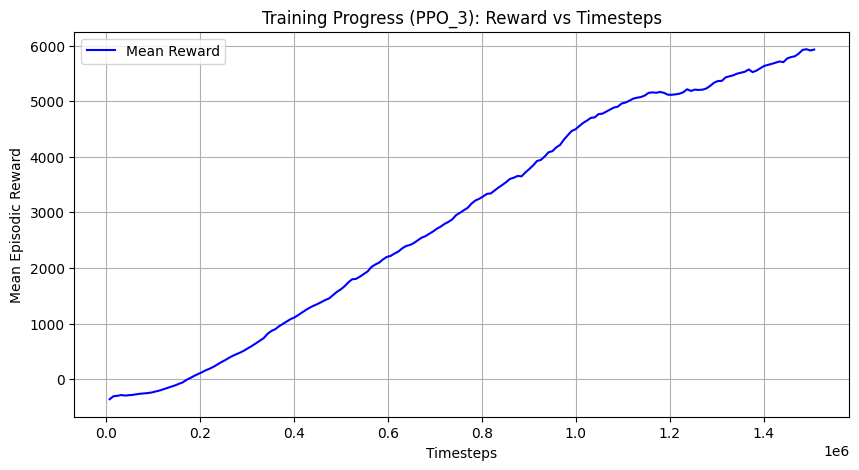

In [12]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Percorso principale del log di TensorBoard
log_dir = "./ppo_HalfCheetah_tensorboard/"

# Selezione della sottocartella specifica contenente i dati del training
# Cambiare il valore di `selected_subdir` per visualizzare i dati di altre sessioni di training.
selected_subdir = "PPO_3"  # Opzioni possibili: "PPO_1", "PPO_2", ecc.

# Costruzione del percorso completo della cartella selezionata
selected_path = os.path.join(log_dir, selected_subdir)

# Verifica che il percorso esista, altrimenti genera un errore
if not os.path.exists(selected_path):
    raise FileNotFoundError(f"La cartella {selected_subdir} non esiste in {log_dir}")

print(f"Caricando dati da: {selected_path}")

# Ricerca automatica del file degli eventi TensorBoard nella cartella selezionata
event_file = None
for root, dirs, files in os.walk(selected_path):
    for file in files:
        if "events.out.tfevents" in file:  # Identifica il file corretto
            event_file = os.path.join(root, file)
            break  # Esce dal loop dopo aver trovato il primo file valido

# Se nessun file TensorBoard viene trovato, genera un errore
if event_file is None:
    raise FileNotFoundError(f"Nessun file TensorBoard trovato in {selected_path}")

# Caricamento dei dati dal file TensorBoard
event_acc = EventAccumulator(event_file)
event_acc.Reload()  # Legge i dati memorizzati

# Liste per memorizzare i timesteps e le ricompense medie durante il training
timesteps = []
mean_rewards = []

# Estrazione dei dati dalla metrica "rollout/ep_rew_mean" (ricompensa media per episodio)
for event in event_acc.Scalars("rollout/ep_rew_mean"):
    timesteps.append(event.step)  # Numero di timesteps corrispondente alla misurazione
    mean_rewards.append(event.value)  # Ricompensa media registrata in quel momento

# Creazione del grafico dell'andamento del training
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_rewards, label="Mean Reward", color="blue")  # Linea della ricompensa media
plt.xlabel("Timesteps")  # Etichetta asse X
plt.ylabel("Mean Episodic Reward")  # Etichetta asse Y
plt.title(f"Training Progress ({selected_subdir}): Reward vs Timesteps")  # Titolo del grafico
plt.legend()  # Mostra la legenda
plt.grid(True)  # Attiva la griglia di sfondo per migliorare la leggibilità
plt.show()  # Visualizza il grafico


Trained Policy: Mean Reward: 7176.00 ± 92.17
Random Policy: Mean Reward: -313.24 ± 120.58


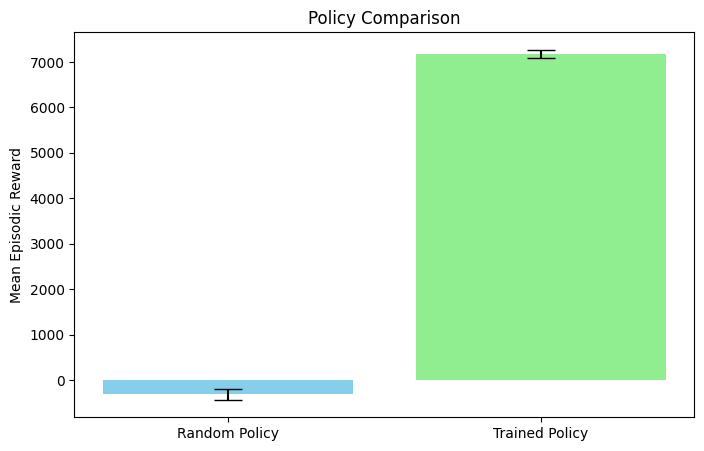

In [11]:
# Percorsi dei file salvati del modello e della normalizzazione
model_path = "./ppo_HalfCheetah_model.zip"
vecnormalize_path = "./vecnormalize_HalfCheetah.pkl"

# Controlla che i file esistano prima di caricarli
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Modello non trovato: {model_path}")
if not os.path.exists(vecnormalize_path):
    raise FileNotFoundError(f"File di normalizzazione non trovato: {vecnormalize_path}")

# Selezione automatica del device per l'esecuzione (GPU se disponibile, altrimenti CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Caricamento del modello PPO addestrato
model = PPO.load(model_path, device=device)


'''
CustomRewardWrapper: Wrapper personalizzato per modificare la ricompensa
- Penalizza il modello se il torso dell'agente si inclina oltre una certa soglia
- La penalità aumenta in base al tempo trascorso in questa condizione
'''
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        """
        Esegue un'azione nell'ambiente e applica una penalità se l'agente si inclina troppo.

        - Se l'agente si inclina oltre una certa soglia (torso_angle < -0.7), viene applicata una penalità crescente
          in base al tempo trascorso in questa condizione.
        - La penalità viene aggiunta alla ricompensa originale per scoraggiare comportamenti indesiderati.
        - Se l'agente si rialza, il timer della penalità viene azzerato.

        Parametri:
        - action: Azione da eseguire nell'ambiente.

        Ritorna:
        - obs: Nuovo stato dell'ambiente dopo l'azione.
        - reward: Ricompensa modificata con eventuale penalità applicata.
        - terminated: Indica se l'episodio è terminato.
        - truncated: Indica se l'episodio è stato interrotto per altri motivi.
        - info: Informazioni aggiuntive sull'episodio.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Estrae l'angolo del torso dall'ambiente
        torso_angle = self.env.unwrapped.data.qpos[2]

        # Inizializza il timer al primo step
        if not hasattr(self, 'cappottato_start_time'):
            self.cappottato_start_time = None

        # Se l'agente si è ribaltato (torso inclinato troppo)
        if torso_angle < -0.7:
            if self.cappottato_start_time is None:  # Se è la prima volta che cade
                self.cappottato_start_time = time.time()  # Registra il tempo d'inizio

            # Calcola il tempo totale passato in questa condizione
            tempo_cappottato = time.time() - self.cappottato_start_time

            # Applica una penalità crescente nel tempo
            penalty = 50 * tempo_cappottato
            reward -= penalty

        else:  # Se l'agente si è ripreso, resetta il timer
            self.cappottato_start_time = None

        return obs, reward, terminated, truncated, info



'''
make_env: Funzione per creare un ambiente personalizzato
- Imposta i parametri ottimizzati dell'ambiente
- Applica un Monitor per tracciare le performance
- Usa il wrapper CustomRewardWrapper per modificare la ricompensa
'''
def make_env():
    def _init():
        env = gym.make("HalfCheetah-v5",
                        reset_noise_scale=0.013459312664159742,
                        forward_reward_weight=1.4435374113892951,
                        ctrl_cost_weight=0.09129087622076545)
        env = Monitor(env)  # Registra le metriche dell'episodio
        env = CustomRewardWrapper(env)  # Applica il wrapper personalizzato
        return env
    return _init

# Creazione dell'ambiente di valutazione con normalizzazione caricata
eval_env = DummyVecEnv([make_env()])
eval_env = VecNormalize.load(vecnormalize_path, eval_env)  # Carica la normalizzazione salvata
eval_env.training = False  # Disabilita la normalizzazione in fase di valutazione
eval_env.reset()


'''
evaluate_random_policy: Funzione per valutare una policy casuale
- Genera azioni casuali e le esegue nell'ambiente
- Registra la ricompensa media ottenuta su più episodi
'''
def evaluate_random_policy(env, episodes=100):
    total_rewards = []

    for _ in range(episodes):
        obs = env.reset()
        done = [False] * env.num_envs  # Tiene traccia degli episodi terminati
        episode_rewards = np.zeros(env.num_envs)  # Array per sommare le ricompense

        while not all(done):  # Continua finché tutti gli episodi non sono finiti
            actions = [env.action_space.sample() for _ in range(env.num_envs)]  # Azioni casuali
            obs, rewards, done, _ = env.step(actions)
            episode_rewards += rewards  # Accumula le ricompense

        total_rewards.extend(episode_rewards)  # Memorizza le ricompense totali

    # Calcola la media e la deviazione standard delle ricompense ottenute
    mean_reward_random = np.mean(total_rewards)
    std_reward_random = np.std(total_rewards)
    return mean_reward_random, std_reward_random


# Valutazione del modello addestrato
mean_reward_trained, std_reward_trained = evaluate_policy(model, eval_env, n_eval_episodes=100, deterministic=True)

# Valutazione di una policy casuale
mean_reward_random, std_reward_random = evaluate_random_policy(eval_env, episodes=100)


# Stampa dei risultati a confronto
print(f"Trained Policy: Mean Reward: {mean_reward_trained:.2f} ± {std_reward_trained:.2f}")
print(f"Random Policy: Mean Reward: {mean_reward_random:.2f} ± {std_reward_random:.2f}")


# Creazione del grafico di confronto tra policy casuale e policy addestrata
labels = ['Random Policy', 'Trained Policy']
means = [mean_reward_random, mean_reward_trained]
stds = [std_reward_random, std_reward_trained]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=stds, capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('Mean Episodic Reward')  # Etichetta asse Y
plt.title('Policy Comparison')  # Titolo del grafico
plt.show()
